In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pygmt
import os
import yaml
import pandas as pd
import h5py

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from scipy import interpolate

In [3]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import mathlib

In [4]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/'

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
#dir_model_fund = dir_project + info_basic['rdir_model_fund']
#dir_model = dir_project + info_basic['rdir_model']
#dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo_Re-srl/'
dir_image = dir_project_workspace + 'paper_tomo_SRL-2.0/raw/'
dir_disp = dir_project + info_basic['rdir_disp_model']
dir_disp_pick = dir_project + info_basic['rdir_disp_pick']
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [8]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [9]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

key_subworks_all = info_basic['key_subworks']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 

stations_this = {}
lat_stations_this = {}
lon_stations_this = {}
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_this[key] = stations_this
    lat_stations_this[key] = lat.astype(float)
    lon_stations_this[key] = lon.astype(float)

stations_probes = {}
lat_probes = {}
lon_probes = {}
lon_centroid_probes = []
lat_centroid_probes = []
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)
    lon_centroid_probes.append(np.mean(lon_this.astype(float)))
    lat_centroid_probes.append(np.mean(lat_this.astype(float)))

stations_targets = {}
lat_targets = {}
lon_targets = {}
lon_centroid_targets = []
lat_centroid_targets = []
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    lon_centroid_targets.append(np.mean(lon_this.astype(float)))
    lat_centroid_targets.append(np.mean(lat_this.astype(float)))

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [11]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lon_centroid_partition = []
lat_centroid_partition = []
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat.astype(float)
    lon_stations_partition[key] = lon.astype(float)
    lon_centroid_partition.append(np.mean(lon.astype(float)))
    lat_centroid_partition.append(np.mean(lat.astype(float)))

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

### Probes and Targets

In [13]:
def extract_probes(target):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stations_targets

    stas = stations_targets[target]
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [14]:
def find_nearest(lon_this,lat_this,lon_stations_all,lat_stations_all):
    lon_stations_all = np.array(lon_stations_all)
    lat_stations_all = np.array(lat_stations_all)
    lon_stations_all = lon_stations_all.reshape(-1,1)
    lat_stations_all = lat_stations_all.reshape(-1,1)
    dist = np.sqrt((lon_stations_all-lon_this)**2+(lat_stations_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    #print(lon_stations_all)
    #print(index)
    return index

In [15]:
key_subwork = '277--26-10'
key_probe = '24-10'
key_target = '26-10'
f_range = [10,16]

points = np.column_stack((lon_targets[key_target],lat_targets[key_target]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_target = list(points[hull.vertices,0])
lon_edge_target.append(points[hull.vertices,0][0])
lat_edge_target = list(points[hull.vertices,1])
lat_edge_target.append(points[hull.vertices,1][0])

points = np.column_stack((lon_probes[key_probe],lat_probes[key_probe]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_probe = list(points[hull.vertices,0])
lon_edge_probe.append(points[hull.vertices,0][0])
lat_edge_probe = list(points[hull.vertices,1])
lat_edge_probe.append(points[hull.vertices,1][0])

points = np.column_stack((lon_stations_partition[key_subwork],lat_stations_partition[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
disp_all = {}
for probe in probes_this:
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp_all[probe] = disp[index,:]
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])
# calculate relative error between all probes and reference probe
err = []
f_sample = np.linspace(f_range[0],f_range[1],200,endpoint=False)
f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
c_pick_ref = f(f_sample)
c_pick = {}
for probe in probes_this:
    c_pick[probe] = []
    file_ds = dir_disp_probes + 'autopick_'+probe+'.txt'
    disp = np.loadtxt(file_ds,delimiter=',')
    index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
    disp = disp[index,:]
    f_this = disp[:,0]
    c_this = disp[:,1]
    # 生成插值函数,可以外推
    #f = interpolate.interp1d(f_this,c_this,kind='cubic')
    f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
    c_pick[probe] = f(f_sample)

    max_disp = np.sum( np.maximum(np.array(c_pick_ref),np.array(c_pick[probe])) )
    abs_err = np.sum( np.abs(np.abs(np.array(c_pick_ref))-np.abs(np.array(c_pick[probe]))) )
    err.append(abs_err/max_disp) 

In [16]:
flag_red = 0.001
flag_proj = 'M10c'

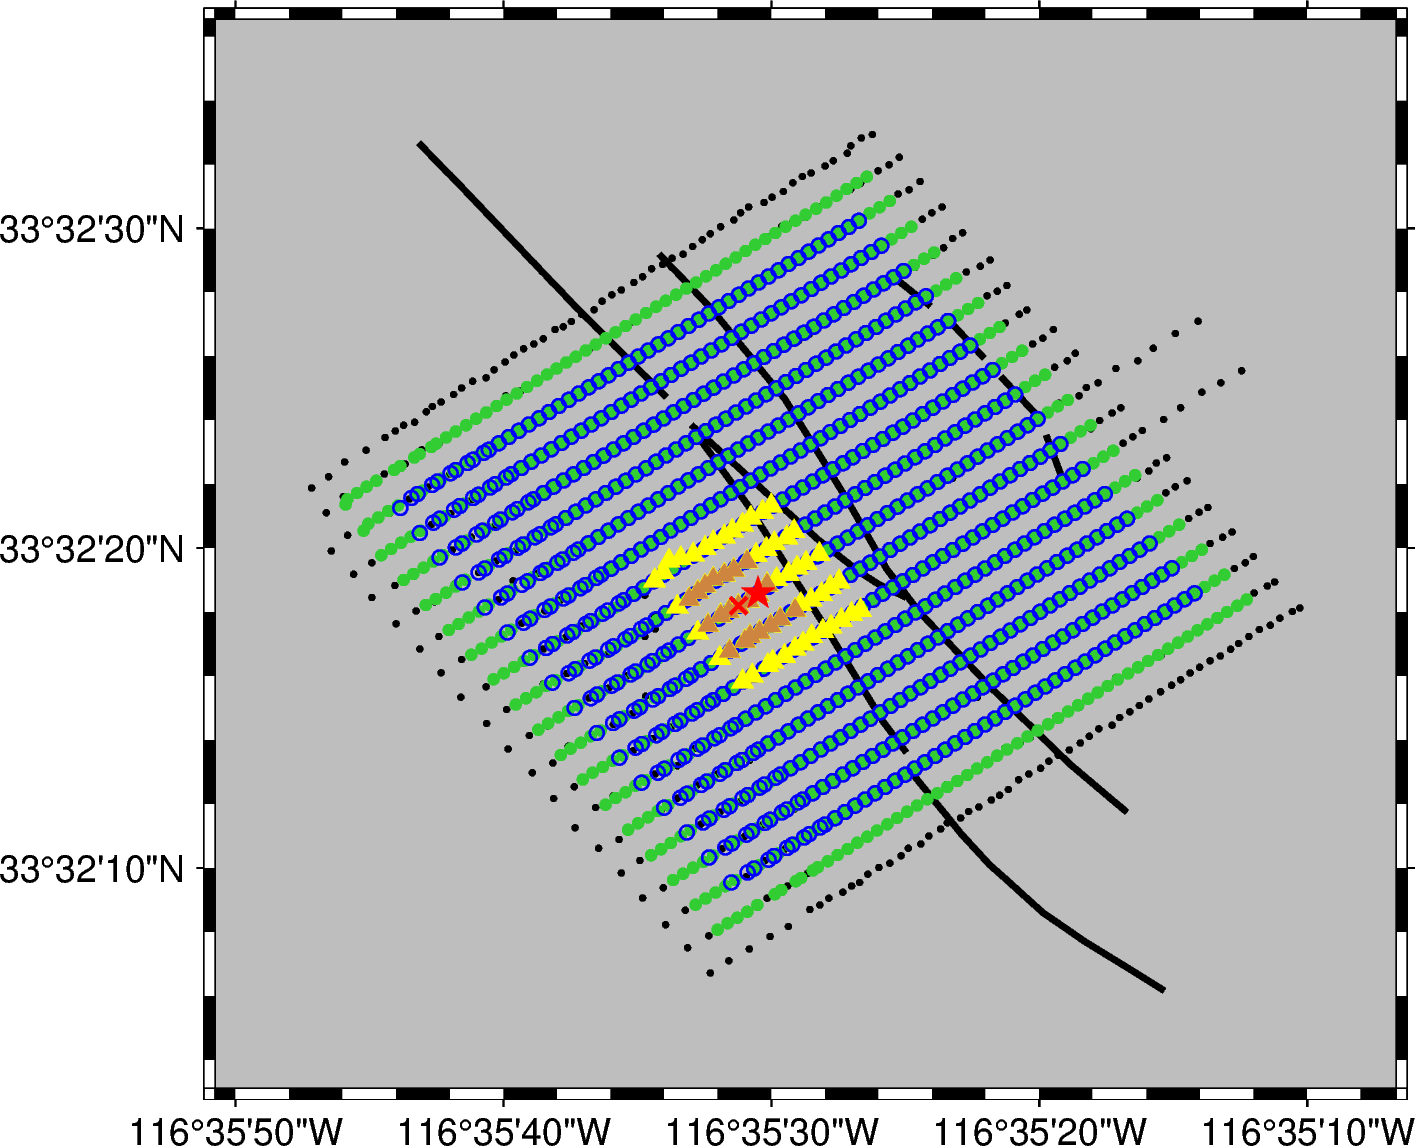

In [17]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame='f',
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# targets and probes
fig.plot(x=lon_centroid_probes, y=lat_centroid_probes, style='c0.1',fill='limegreen' , label='All Probes centroid')
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.5p,blue', label='All targets centroid')
# sample target and probe
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='t0.22',fill = 'yellow', label='Arrays of sample target')
fig.plot(x=lon_probes[key_probe], y=lat_probes[key_probe], style='t0.2',fill = 'peru', label='Arrays of sample probe')
#fig.plot(x=lon_edge_target, y=lat_edge_target, pen='1p,yellow', label='target boundary')
#fig.plot(x=lon_edge_probe, y=lat_edge_probe, pen='1.5p,peru,-', label='probe boundary')
fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='a0.3',fill = 'red', label=' sample target centroid')
fig.plot(x=lon_centroid_probes[probes.index(key_probe)], y=lat_centroid_probes[probes.index(key_probe)], style='x0.2',fill = 'red', label=' sample probe centroid')
#fig.legend(position='jTR+o0.2c', box='+gwhite+p1p')
fig.show()
fig.savefig(dir_image+'partitionworkflow_targetprobe.eps')

### Error distribution

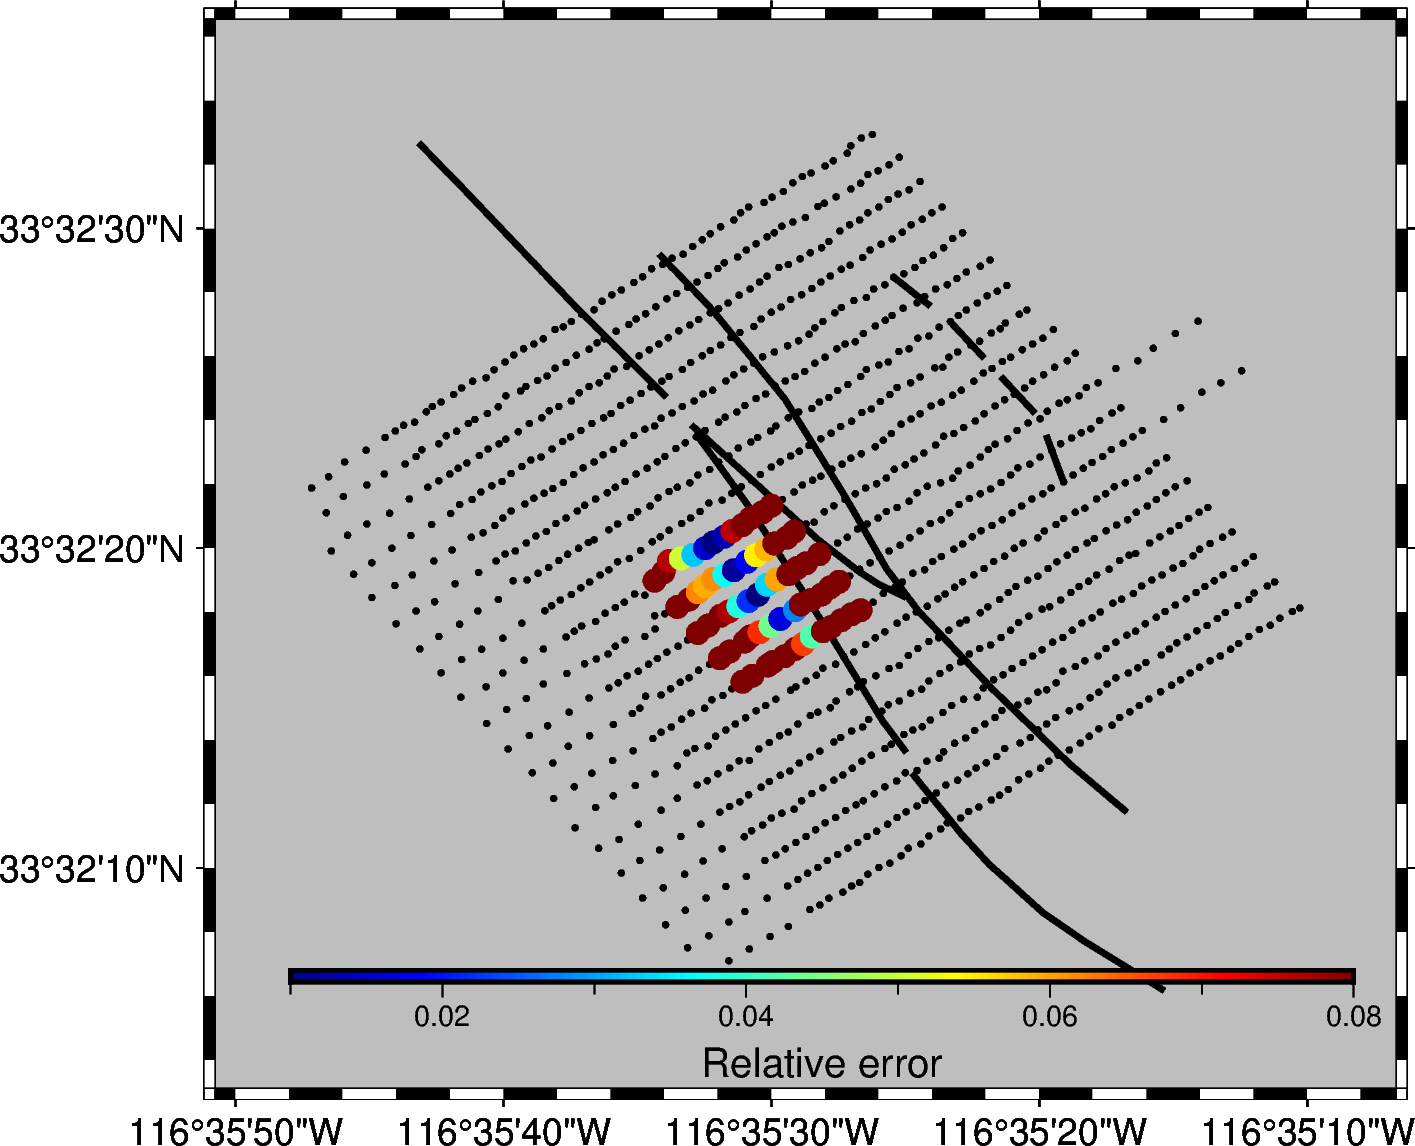

In [18]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# sample target and probe
flag_min = 0.01
flag_max = 0.08
err_norm = []
for i in range(len(err)):
    if err[i] < flag_min:
        err_norm.append(flag_min)
    elif err[i] > flag_max:
        err_norm.append(flag_max)
    else:
        err_norm.append(err[i])
pygmt.makecpt(cmap='jet', series=[flag_min, flag_max])
# colorbar内嵌到图片右下角
fig.colorbar(
    frame='af+l"Relative error"',
    position='JMB+o0.14c/-1.c+w9c/0.1c',
    scale=1
)
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.2',fill=err_norm,cmap = True)
fig.show()
fig.savefig(dir_image+'partitionworkflow_errorDistribution.eps')

### New partition comparison

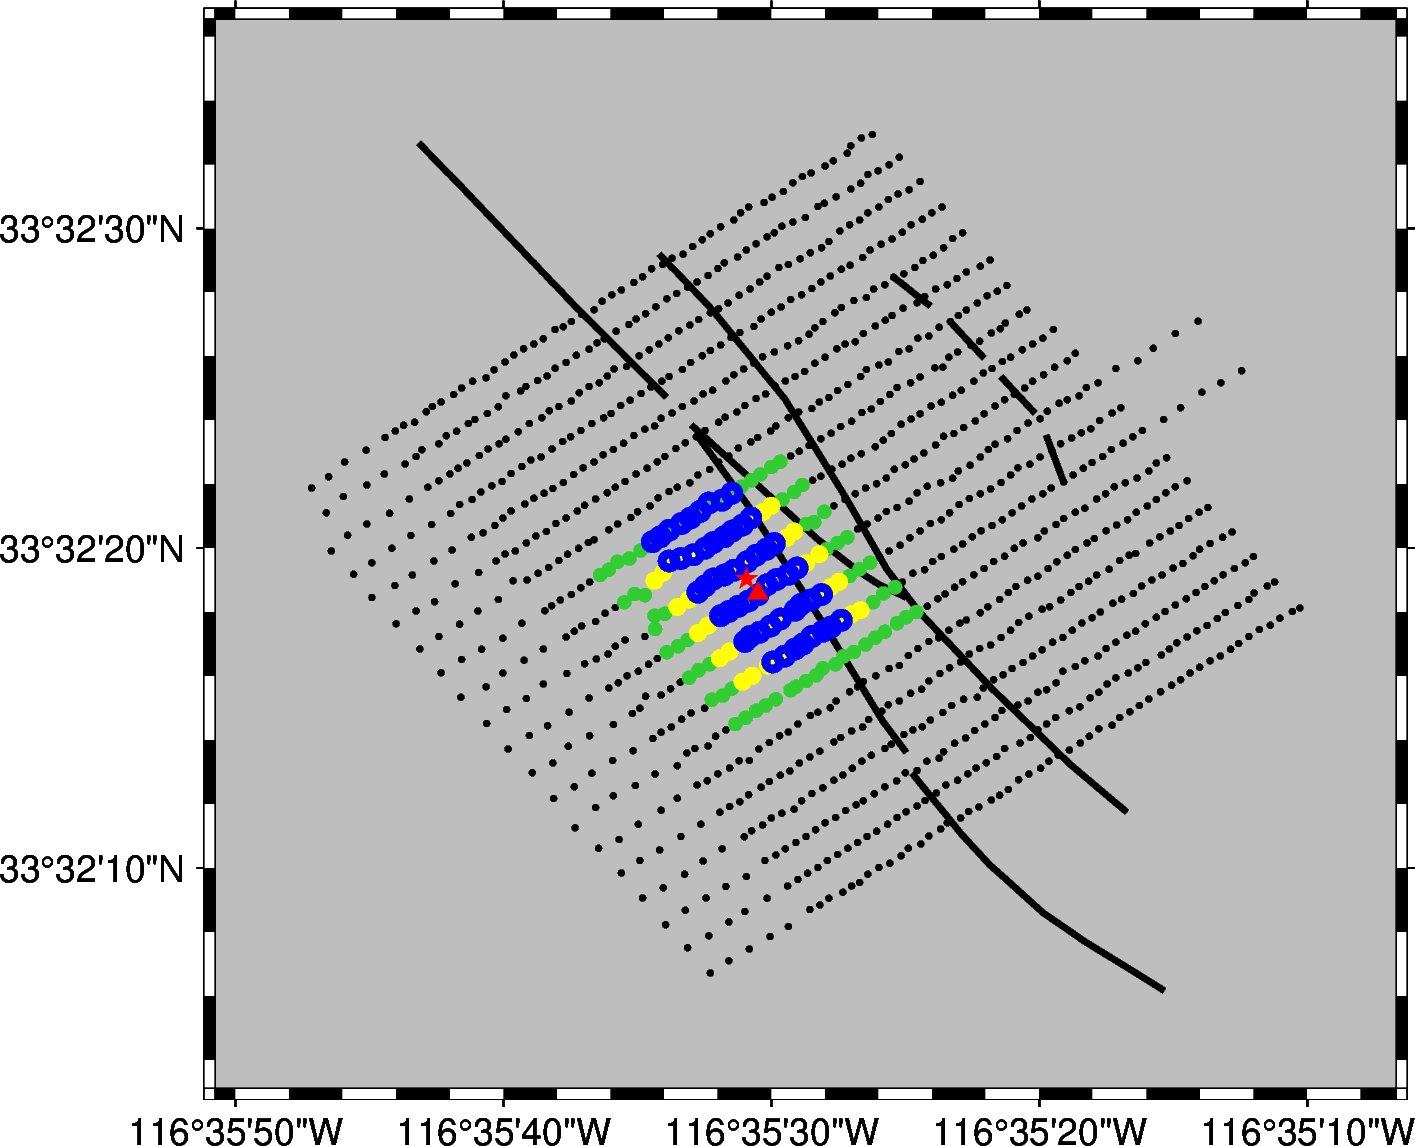

In [19]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.12',fill='limegreen')
fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.15',fill = 'yellow')
fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.12',pen='2p,blue')
fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.2',fill = 'red')
fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'partitionworkflow_newPartition.eps')

### Workflow of FJ

In [20]:
key_subwork = '244--35-09'
#key_subwork = '277--26-10'
# tations_partition[key_subwork],lat_stations_partition[key_subwork]))
points = np.column_stack((lon_stations_partition[key_subwork],lat_stations_partition[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

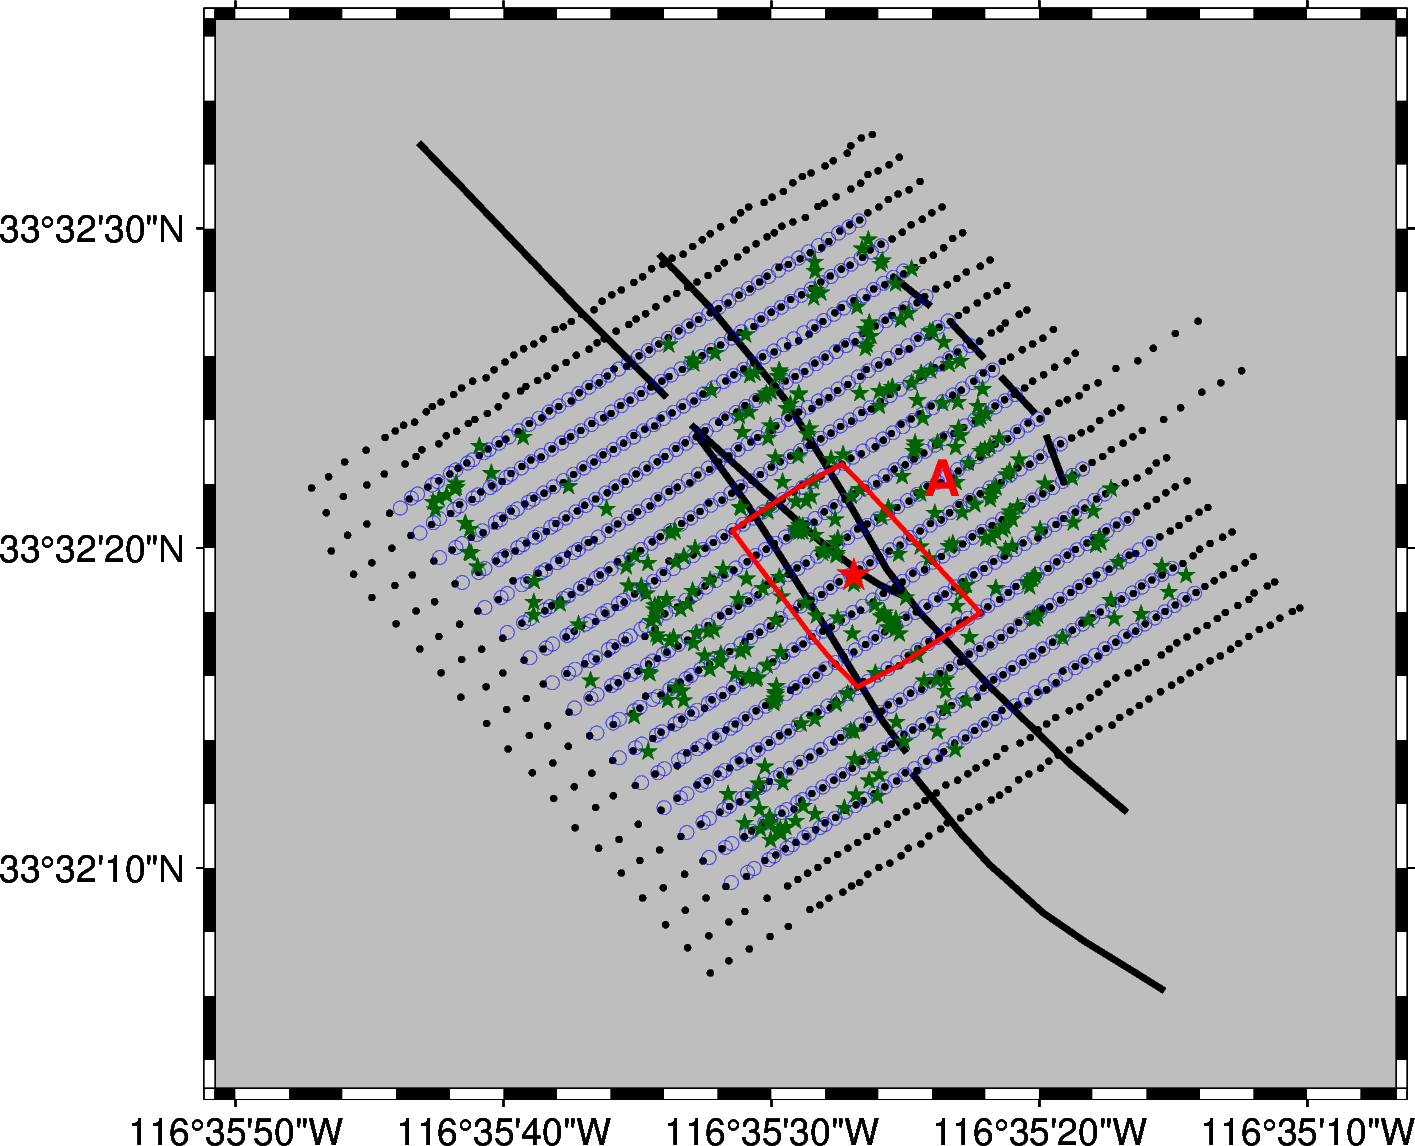

In [21]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# All partitions
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.06p,blue',transparency=40)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.16',fill='darkgreen')
# This partition
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.2',fill='yellow')
fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='1p,red', label='target boundary')
fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
fig.text(text='A', x = -116.5899, y= 33.5395, font="12p,Helvetica-Bold,red")
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
#fig.text(text='S', x = -116.5905, y= 33.538, font="12p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'blind_partition_A.eps')

In [22]:
#key_subwork = '244--35-09'
key_subwork = '23-18'
# tations_partition[key_subwork],lat_stations_partition[key_subwork]))
points = np.column_stack((lon_targets[key_subwork],lat_targets[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

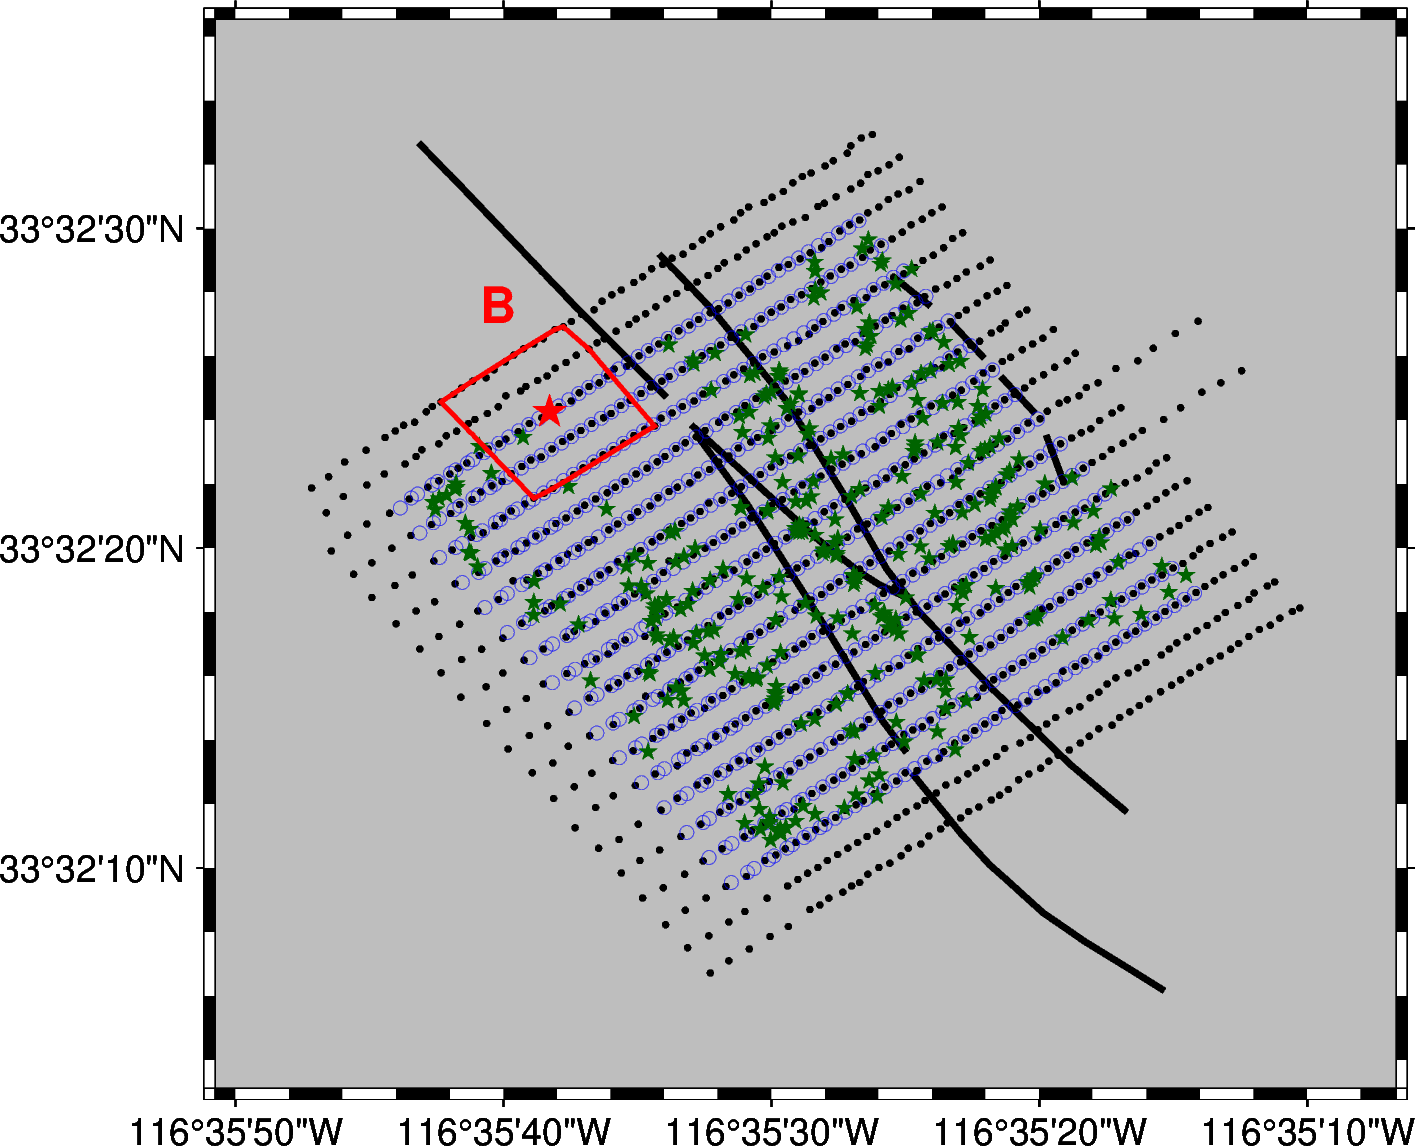

In [23]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# All partitions
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.06p,blue',transparency=40)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.16',fill='darkgreen')
# This partition
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.2',fill='yellow')
fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='1p,red', label='target boundary')
fig.plot(x=np.mean(lon_probes[key_subwork]),y = np.mean(lat_probes[key_subwork]), style='a0.3',fill = 'red')
fig.text(text='B', x = -116.5945, y= 33.5410, font="12p,Helvetica-Bold,red")
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
#fig.text(text='S', x = -116.5905, y= 33.538, font="12p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'blind_partition_B.eps')

In [24]:
#key_subwork = '244--35-09'
key_subwork = '24-15'
# tations_partition[key_subwork],lat_stations_partition[key_subwork]))
points = np.column_stack((lon_targets[key_subwork],lat_targets[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

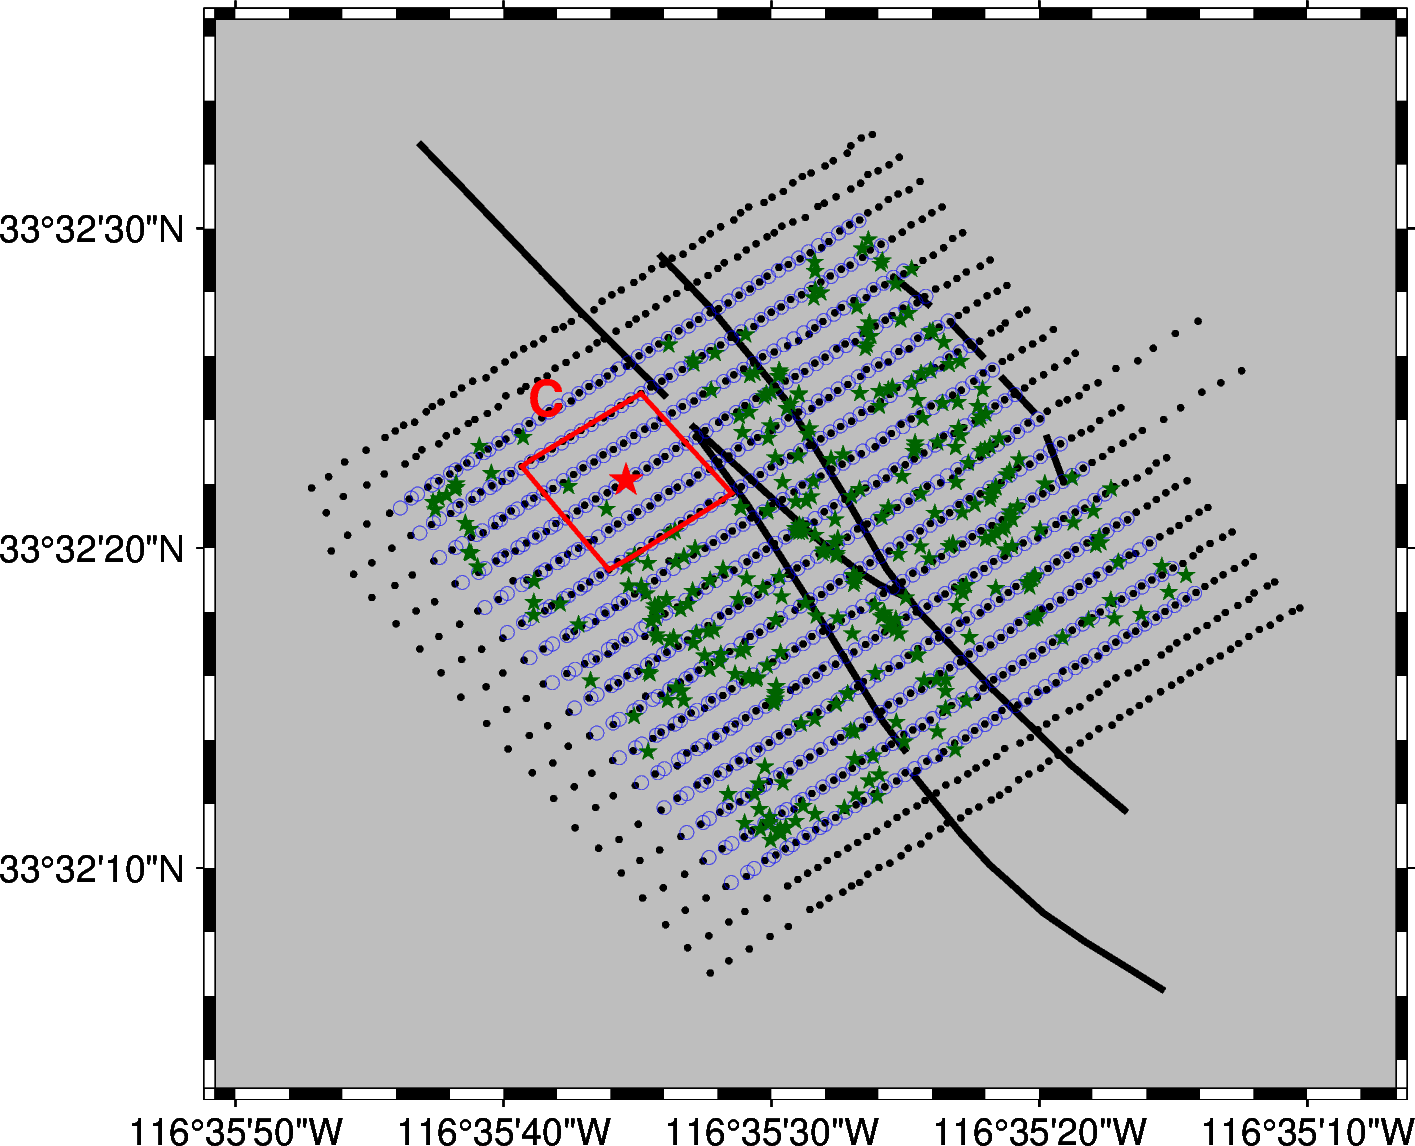

In [25]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# All partitions
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.06p,blue',transparency=40)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.16',fill='darkgreen')
# This partition
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.2',fill='yellow')
fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='1p,red', label='target boundary')
fig.plot(x=np.mean(lon_probes[key_subwork]),y = np.mean(lat_probes[key_subwork]), style='a0.3',fill = 'red')
fig.text(text='C', x = -116.5940, y= 33.5402, font="12p,Helvetica-Bold,red")
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
#fig.text(text='S', x = -116.5905, y= 33.538, font="12p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'blind_partition_C.eps')

### Together

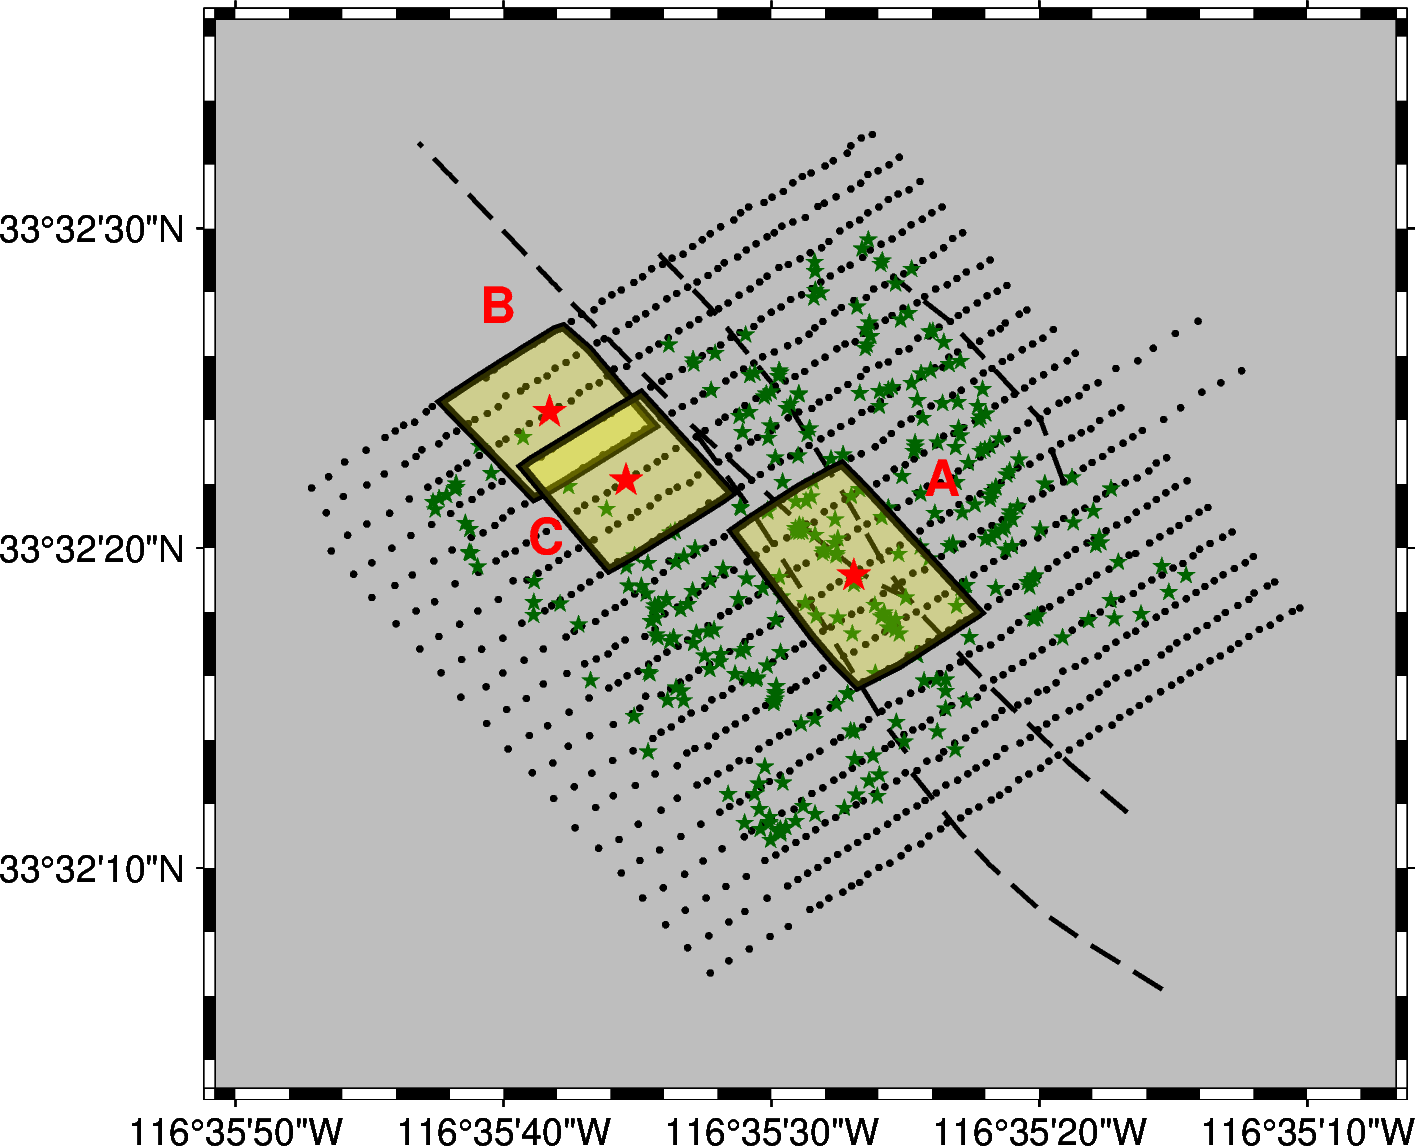

In [55]:
key_subworks = ['244--35-09','23-18','24-15']
labels = ['A','B','C']
lons_label = [-116.5899,-116.5945,-116.5940]
lats_label = [33.5395,33.5410,33.5390]

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1p,black,-")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1p,black,-")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1p,black,-")
# All partitions
#fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.06p,blue',transparency=40)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.16',fill='darkgreen')



for key_subwork in key_subworks:
    if '--' in key_subwork:
        points = np.column_stack((lon_stations_partition[key_subwork],lat_stations_partition[key_subwork]))
    else:
        points = np.column_stack((lon_targets[key_subwork],lat_targets[key_subwork]))
    hull = ConvexHull(points)
    polygon = Polygon(points[hull.vertices])
    lon_edge_partition = list(points[hull.vertices,0])
    lon_edge_partition.append(points[hull.vertices,0][0])
    lat_edge_partition = list(points[hull.vertices,1])
    lat_edge_partition.append(points[hull.vertices,1][0])
    fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='2p,black', label='target boundary')
    fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='2p,black', label='target boundary',fill = 'yellow',transparency=75)
    #填充颜色
    if '--' in key_subwork:
        fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
    else:
        fig.plot(x=np.mean(lon_probes[key_subwork]),y = np.mean(lat_probes[key_subwork]), style='a0.3',fill = 'red')

    index = key_subworks.index(key_subwork)
    fig.text(text=labels[index], x = lons_label[index], y= lats_label[index], font="12p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'blind_partition_all.eps')

In [25]:
#key_subwork = '244--35-09'
key_subwork = '277--26-10'
# tations_partition[key_subwork],lat_stations_partition[key_subwork]))
points = np.column_stack((lon_stations_partition[key_subwork],lat_stations_partition[key_subwork]))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
lon_edge_partition = list(points[hull.vertices,0])
lon_edge_partition.append(points[hull.vertices,0][0])
lat_edge_partition = list(points[hull.vertices,1])
lat_edge_partition.append(points[hull.vertices,1][0])

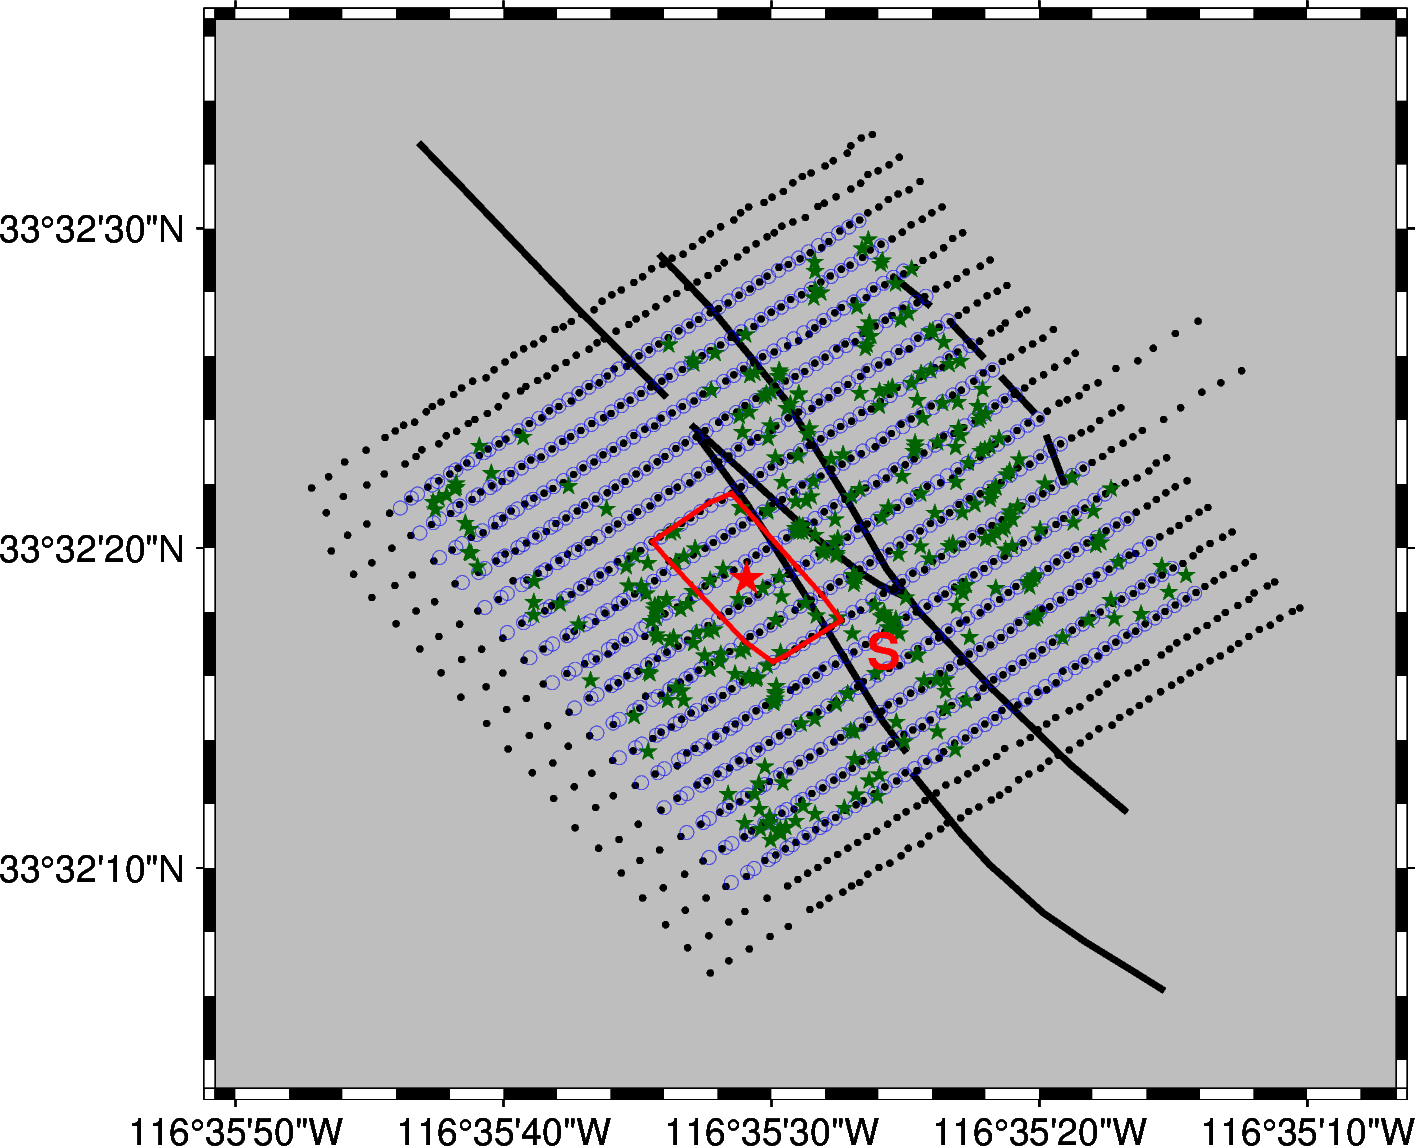

In [26]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# All partitions
fig.plot(x=lon_centroid_targets, y=lat_centroid_targets, style='c0.12',pen='0.06p,blue',transparency=40)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='a0.16',fill='darkgreen')
# This partition
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.2',fill='yellow')
fig.plot(x=lon_edge_partition, y=lat_edge_partition, pen='1p,red', label='target boundary')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
#fig.text(text='S', x = -116.5899, y= 33.5395, font="12p,Helvetica-Bold,red")
fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.3',fill = 'red')
fig.text(text='S', x = -116.5905, y= 33.538, font="12p,Helvetica-Bold,red")
fig.show()
fig.savefig(dir_image+'fjworkflow_partition.eps')

### Vs horizontal

In [27]:
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
inter_file = dir_inv + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [28]:
vs_fund = inter['vs_fund']
vs = inter['vs']
lon_inter_in = inter['lon']
lat_inter_in = inter['lat']
z = inter['depth']
dz = inter['dz']
N = inter['N']

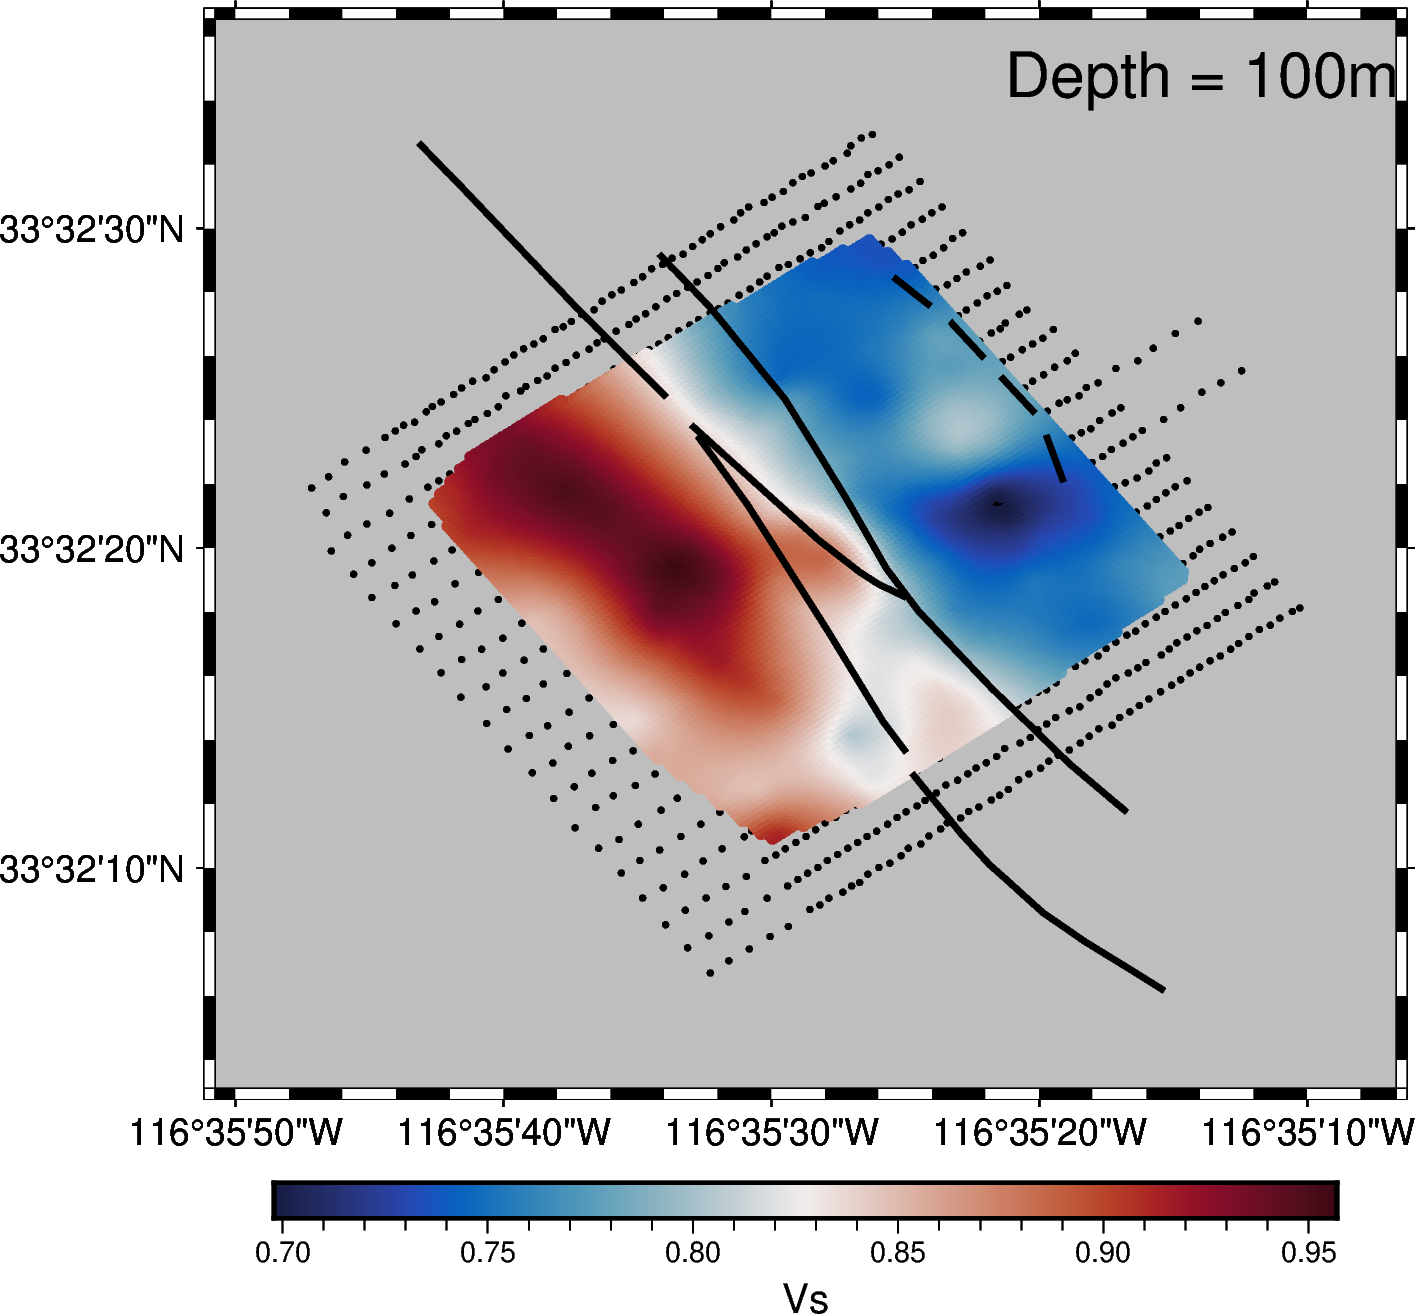

In [29]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
# vs tomography
num_layer = 19
vs_norm = []
#flag_min =  0.7
#flag_max = 0.95
flag_min = np.min(vs[num_layer])
flag_max = np.max(vs[num_layer])
for i in range(len(vs[num_layer])):
    if vs[num_layer][i] < flag_min:
        vs_norm.append(flag_min)
    elif vs[num_layer][i] > flag_max:
        vs_norm.append(flag_max)
    else:
        vs_norm.append(vs[num_layer][i])
pygmt.makecpt(cmap='balance', series=[flag_min, flag_max+0.001])
#fig.colorbar(frame='af+l"Phase velocity"', position='JMR+o0.5c/0c+w9c/0.3c')
fig.colorbar(
    frame='af+l"Vs"',
    position='JMB+o0c/0.8c+w9c/0.3c',
    scale=1,
    cmap=True,
)
fig.plot(x=lon_inter_in, y=lat_inter_in, style='c0.1',fill=vs_norm, cmap = True)
# faults
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
fig.text(text = 'Depth = 100m',x = -116.5872, y= 33.5430,font='15p,Helvetica,black')
fig.show()
fig.savefig(dir_image+'fjworkflow_vs-hori.eps')

### Phase velocity

In [30]:
f_list = [4,8,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in info_basic['key_subworks']:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [31]:
disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
modes = set(disp[:,2])

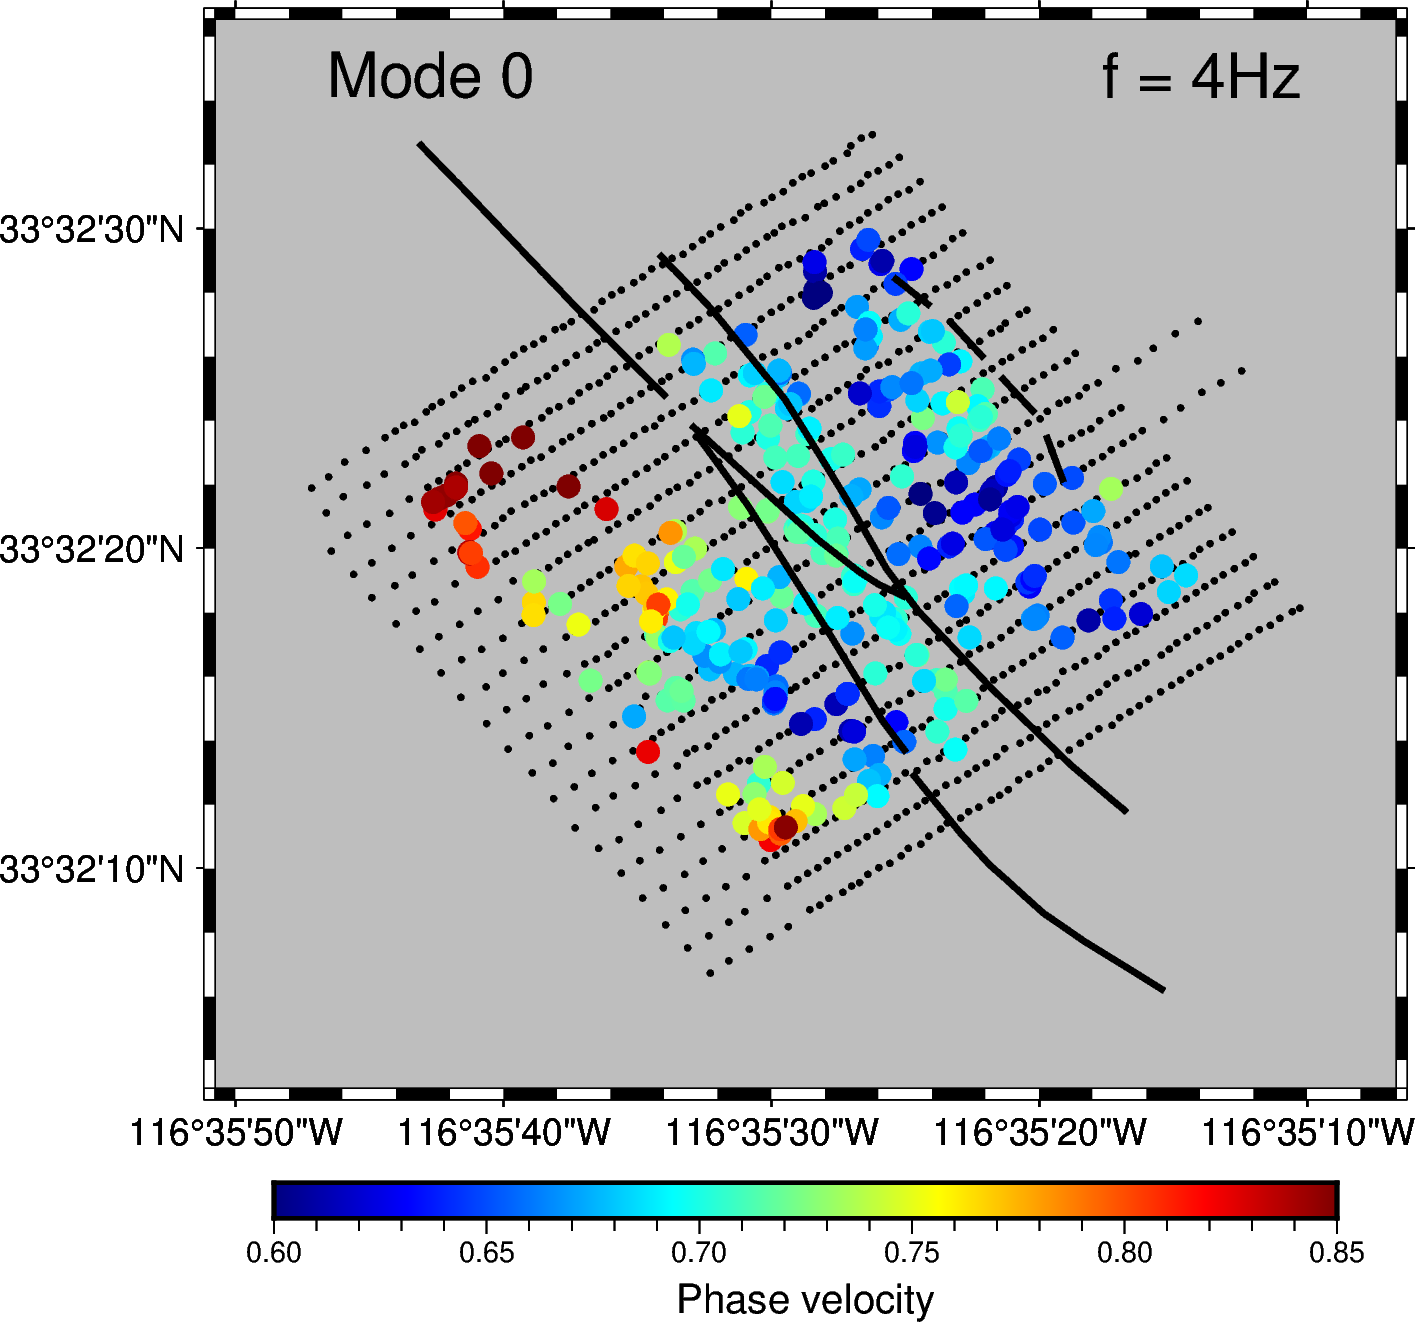

In [32]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
# phase compare
flag_min =  0.6
flag_max = 0.85
flag_f = 0
phase_norm = []
for i in range(len( phase[f_list[flag_f]])):
    if phase[f_list[flag_f]][i] < flag_min:
        phase_norm.append(flag_min)
    elif phase[f_list[flag_f]][i] > flag_max:
        phase_norm.append(flag_max)
    else:
        phase_norm.append(phase[f_list[flag_f]][i])
pygmt.makecpt(cmap='jet', series=[flag_min, flag_max])
#fig.colorbar(frame='af+l"Phase velocity"', position='JMR+o0.5c/0c+w9c/0.3c')
fig.colorbar(
    frame='af+l"Phase velocity"',
    position='JMB+o0c/0.8c+w9c/0.3c',
    scale=1,
    cmap=True,
)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='c0.2',fill=phase_norm, cmap = True)
fig.text(text = 'f = ' + str(f_list[flag_f]) + 'Hz',x = -116.5872, y= 33.5430,font='15p,Helvetica,black')
fig.text(text = 'Mode 0',x = -116.5952, y= 33.5430,font='15p,Helvetica,black')
# faults
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
fig.savefig(dir_image+'phase_'+str(f_list[flag_f])+'.eps')
fig.show()

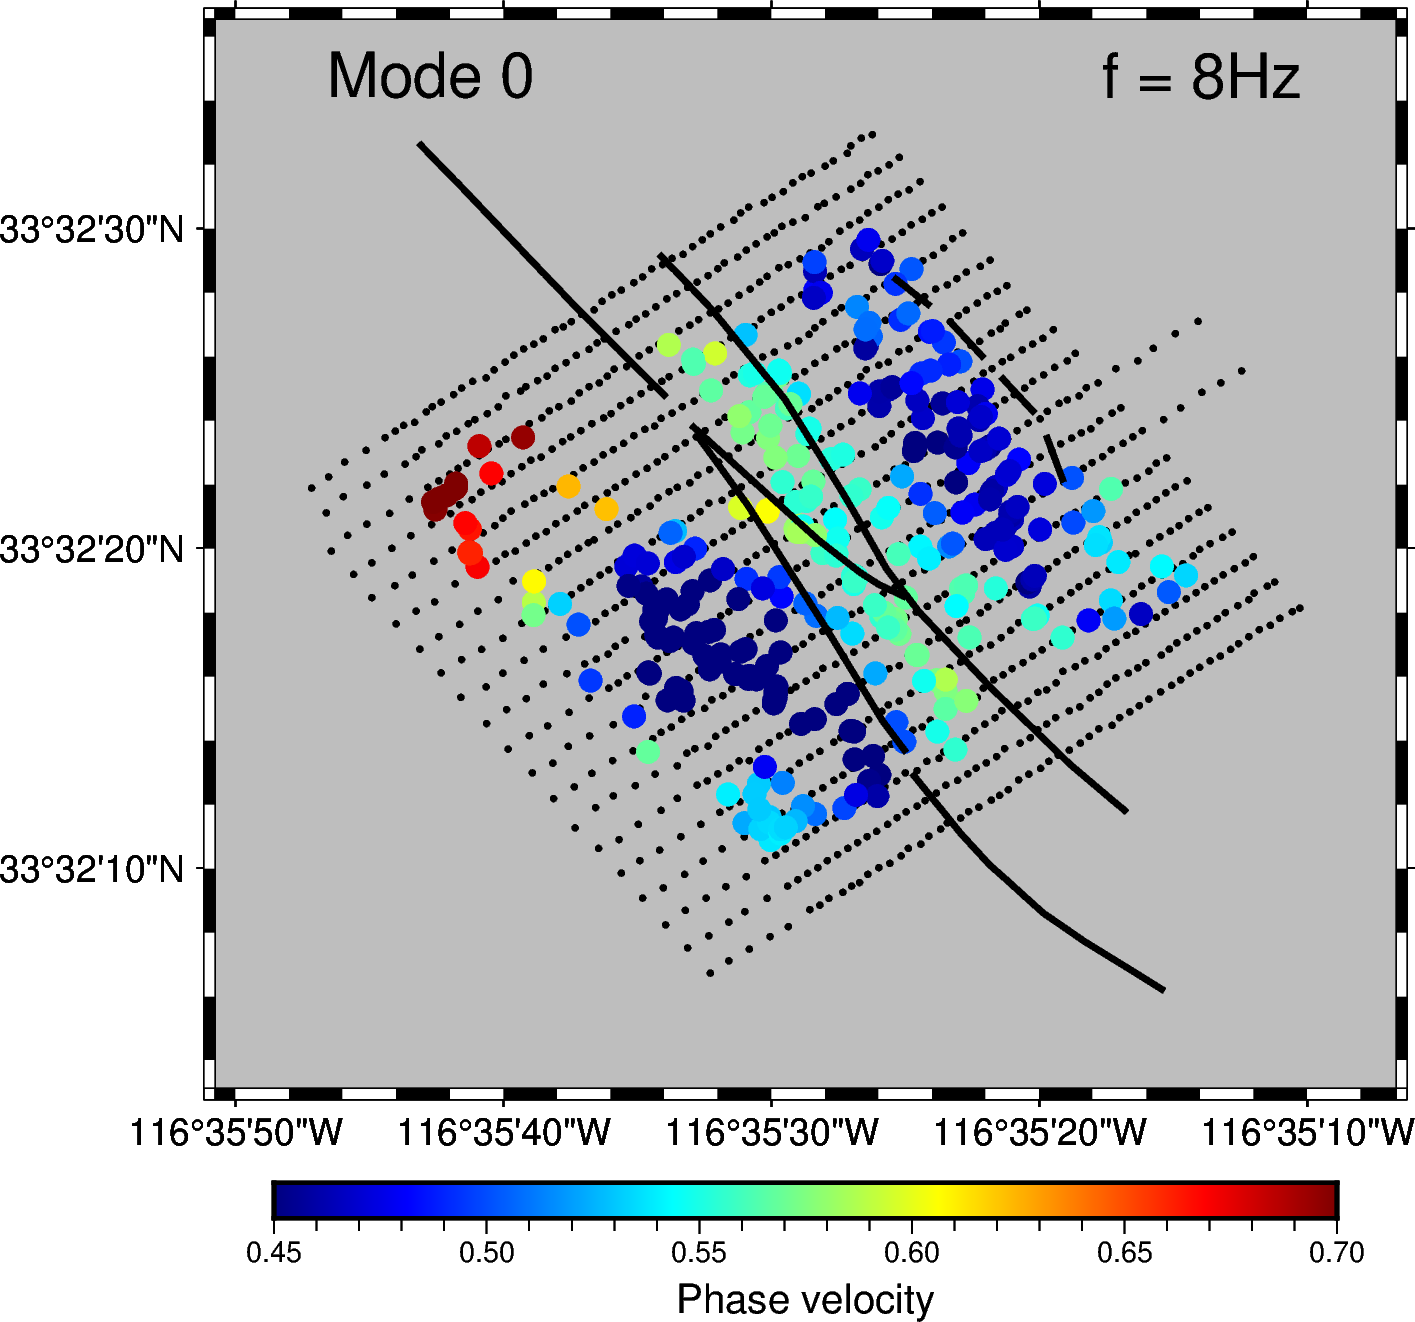

In [33]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
# phase compare
flag_min =  0.45
flag_max = 0.7
flag_f = 1
phase_norm = []
for i in range(len( phase[f_list[flag_f]])):
    if phase[f_list[flag_f]][i] < flag_min:
        phase_norm.append(flag_min)
    elif phase[f_list[flag_f]][i] > flag_max:
        phase_norm.append(flag_max)
    else:
        phase_norm.append(phase[f_list[flag_f]][i])
pygmt.makecpt(cmap='jet', series=[flag_min, flag_max])
#fig.colorbar(frame='af+l"Phase velocity"', position='JMR+o0.5c/0c+w9c/0.3c')
fig.colorbar(
    frame='af+l"Phase velocity"',
    position='JMB+o0c/0.8c+w9c/0.3c',
    scale=1,
    cmap=True,
)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='c0.2',fill=phase_norm, cmap = True)
fig.text(text = 'f = ' + str(f_list[flag_f]) + 'Hz',x = -116.5872, y= 33.5430,font='15p,Helvetica,black')
fig.text(text = 'Mode 0',x = -116.5952, y= 33.5430,font='15p,Helvetica,black')
# faults
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
fig.savefig(dir_image+'phase_'+str(f_list[flag_f])+'.eps')
fig.show()

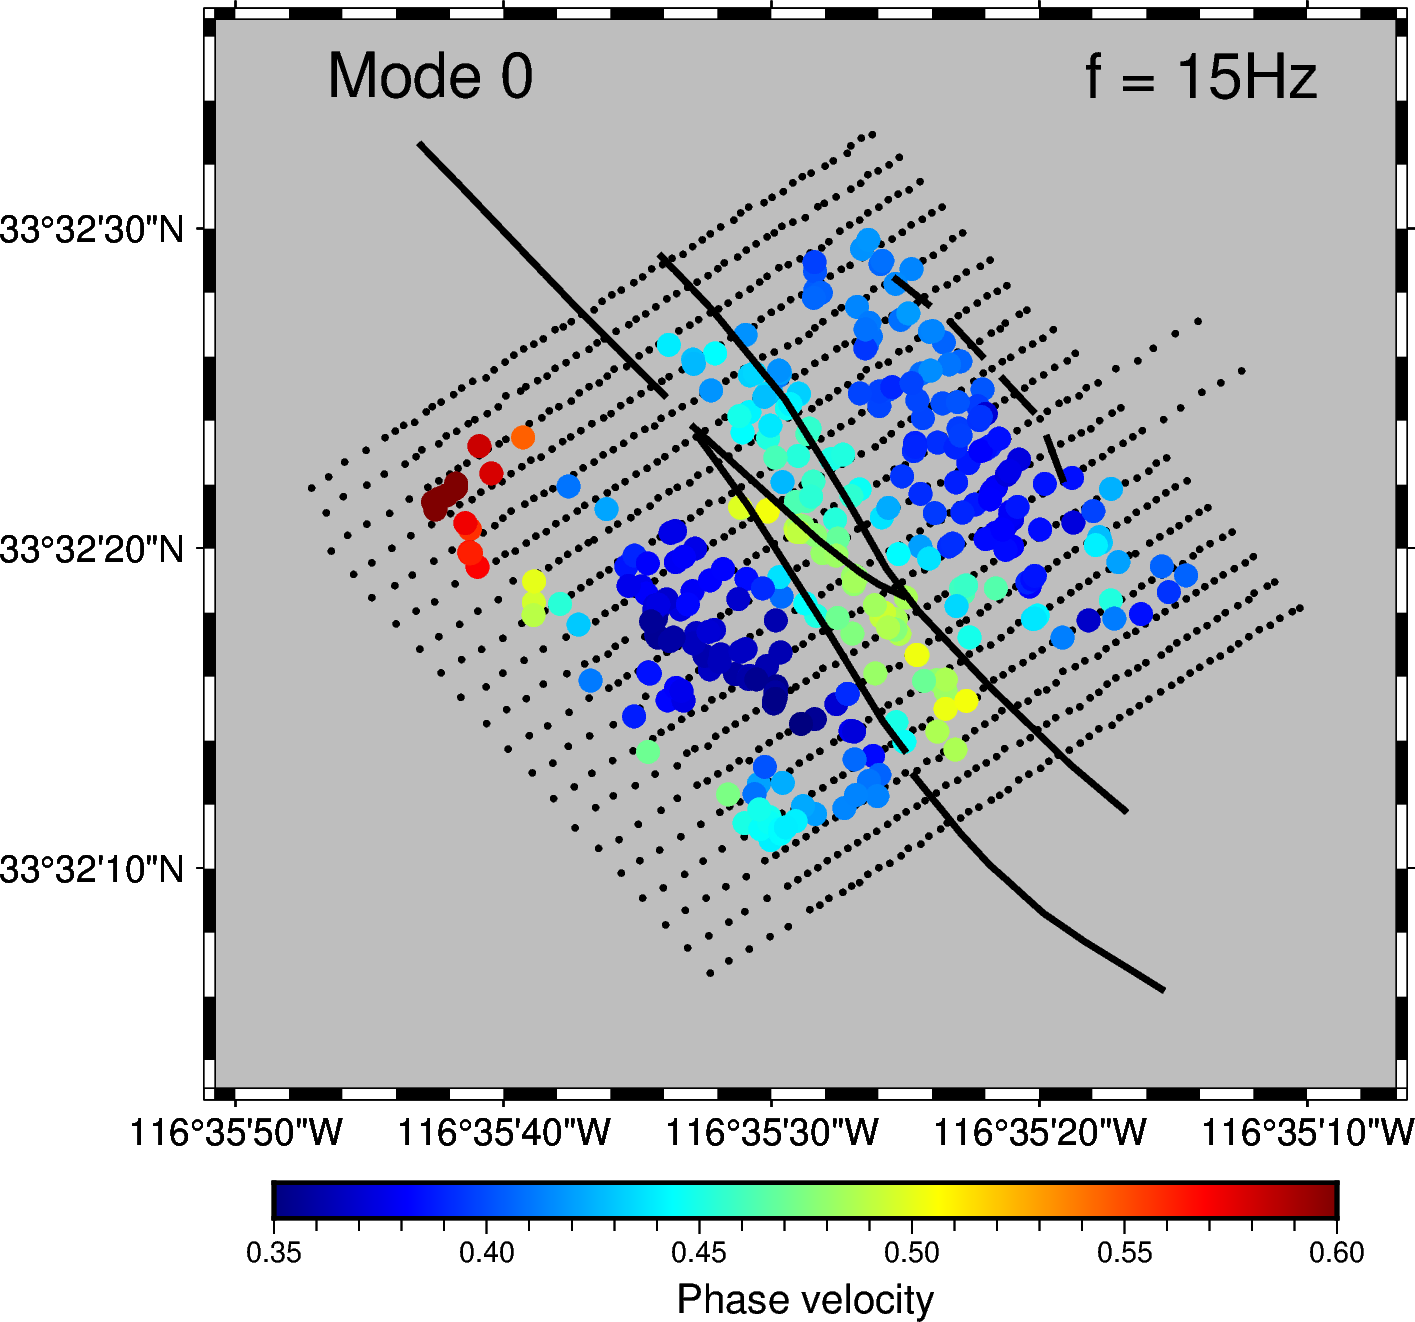

In [34]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
# phase compare
flag_min =  0.35
flag_max = 0.6
flag_f = 2
phase_norm = []
for i in range(len( phase[f_list[flag_f]])):
    if phase[f_list[flag_f]][i] < flag_min:
        phase_norm.append(flag_min)
    elif phase[f_list[flag_f]][i] > flag_max:
        phase_norm.append(flag_max)
    else:
        phase_norm.append(phase[f_list[flag_f]][i])
pygmt.makecpt(cmap='jet', series=[flag_min, flag_max])
#fig.colorbar(frame='af+l"Phase velocity"', position='JMB+o0.5c/0c+w9c/0.3c')
fig.colorbar(
    frame='af+l"Phase velocity"',
    position='JMB+o0c/0.8c+w9c/0.3c',
    scale=1,
    cmap=True,
)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='c0.2',fill=phase_norm, cmap = True)
fig.text(text = 'f = ' + str(f_list[flag_f]) + 'Hz',x = -116.5872, y= 33.5430,font='15p,Helvetica,black')
fig.text(text = 'Mode 0',x = -116.5952, y= 33.5430,font='15p,Helvetica,black')
# fautls
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
fig.savefig(dir_image+'phase_'+str(f_list[flag_f])+'.eps')
fig.show()

### Show higher modes

In [35]:
max_tag = []
for key in info_basic['key_subworks']:
    disp = np.loadtxt(dir_disp_pick + 'ds_'+key+'curve.txt')
    modes = set(disp[:,2])
    max_tag.append(max(modes))

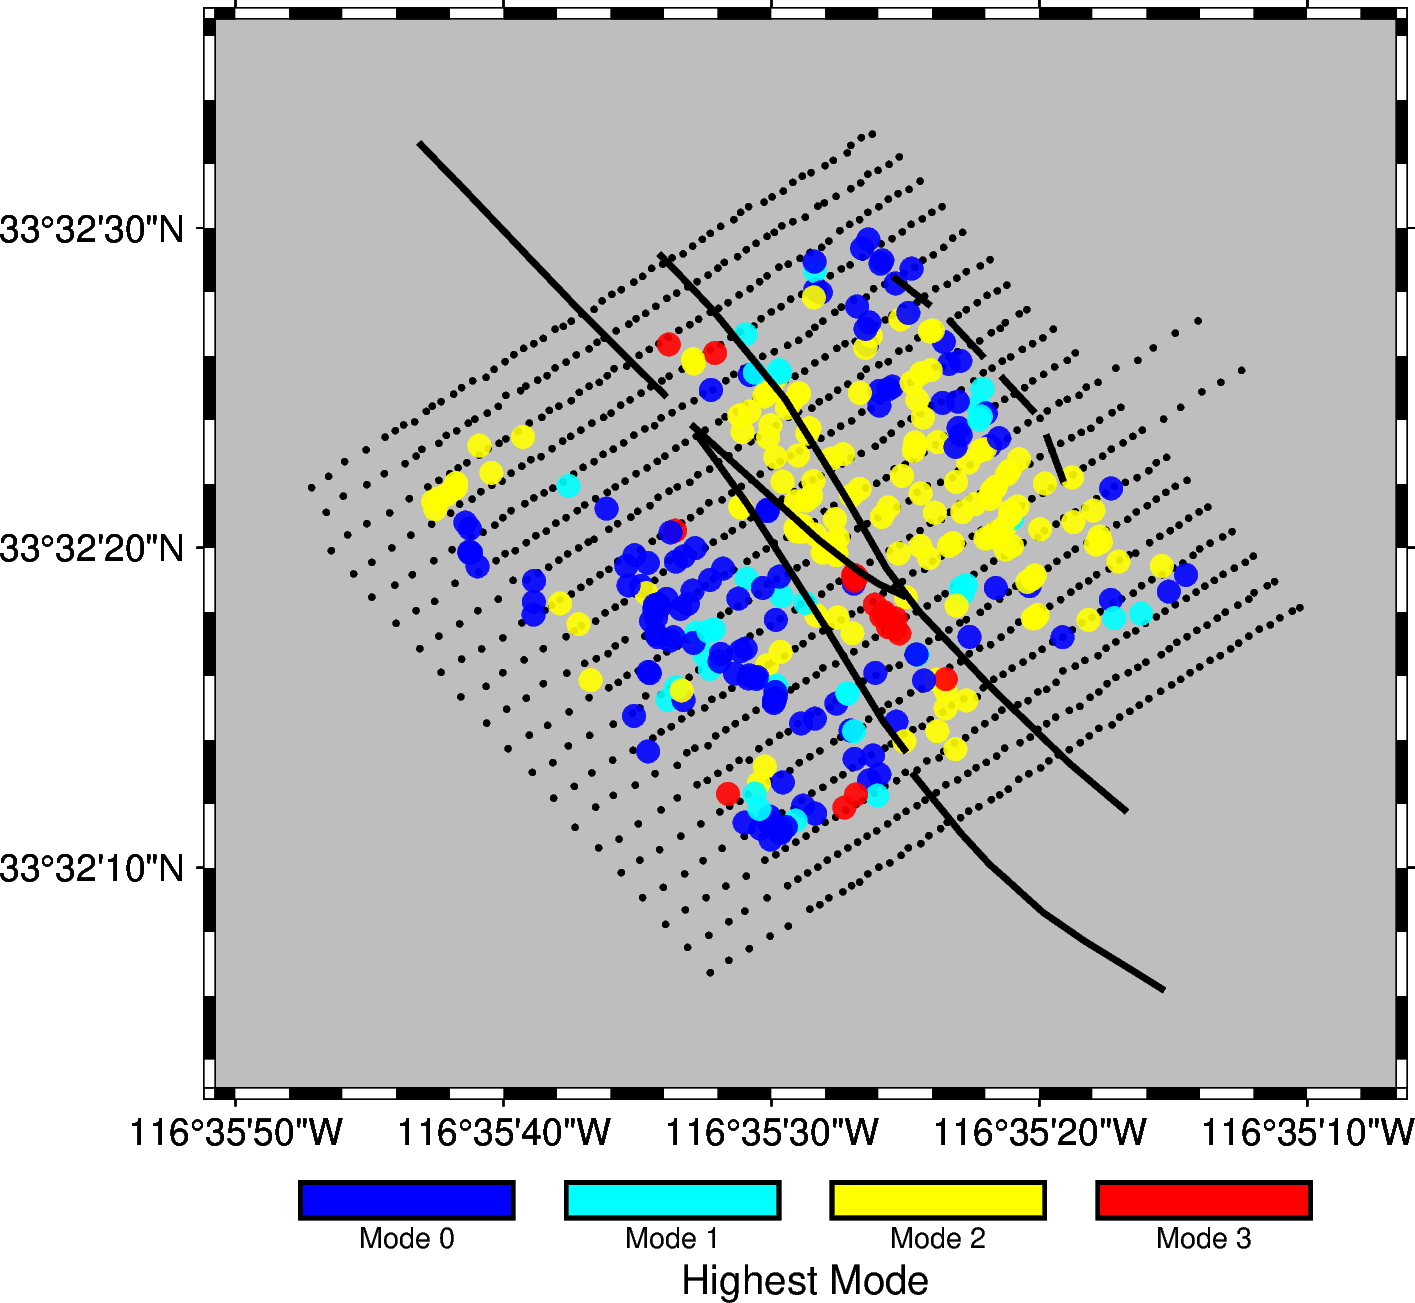

In [36]:
fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
#fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='c0.2',fill='')
# mode distribution
pygmt.makecpt(cmap="jet", series=[0, 3, 1], color_model="+c" +"Mode 0,Mode 1,Mode 2,Mode 3")

direction = 45
directions = np.ones(len(max_tag))*direction
widths  = np.ones(len(max_tag))*10
heights = np.ones(len(max_tag))*10
data = np.column_stack((np.array(lon_centroid_partition), np.array(lat_centroid_partition), directions, widths,heights))
#for i in range(len(max_tag)):
#    fig.plot(data=data[i],style='s0.2',fill=max_tag[i],cmap=True,transparency=10)
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition,cmap=True, fill = max_tag , style='c0.2',transparency=10)

#fig.plot(data = data,cmap=True, fill = max_tag , style='s0.2',transparency=10)
#fig.plot(x=lon_centroid_partition, y=lat_centroid_partition,cmap=True, fill = max_tag , style='s0.2',transparency=10)
fig.colorbar(
    frame='af+l"Highest Mode"',
    position='JMB+o0c/0.8c+w9c/0.3c',
    scale=1,
    cmap=True,
)
    
# faults
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
fig.savefig(dir_image+'phase_highermodes.eps')
fig.show()